In [4]:
!pip install scikit-learn

In [5]:
!pip install opencv-python

### 환경 세팅 


1. python 버전 3.6.X 버전 사용

2. tensorflow 1.15.X 버전 사용

In [6]:
from PIL import Image
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import requests
import tempfile
from io import BytesIO
import matplotlib.pyplot as plt
from sklearn.cluster import MeanShift, estimate_bandwidth
import cv2
import subprocess
import os

In [11]:
def segment_image(image, k=3):

    # 이미지를 NumPy 배열로 변환
    data = np.array(image)

    # 이미지 데이터를 2D로 변환 (각 픽셀은 RGB 색상을 가짐)
    w, h, d = data.shape
    data = data.reshape((w * h, d))

    # KMeans 클러스터링
    kmeans = KMeans(n_clusters=k, random_state=0).fit(data)
    labels = kmeans.predict(data)

    # 클러스터링 결과에 따라 색상 재할당
    segmented_data = kmeans.cluster_centers_.astype('uint8')[labels]

    # 2D 데이터를 원래 이미지 크기로 다시 변환
    segmented_image = segmented_data.reshape((w, h, d))

    return Image.fromarray(segmented_image)

In [12]:
def adjust_brightness_dynamic(image, dark_factor=1.5, bright_factor=1):

    # Ensure the image is a float type for calculations
    if image.dtype != np.float32:
        image = image.astype(np.float32)

    # Find the mean value of the image for threshold
    mean_value = np.mean(image)

    # Apply different factors based on brightness
    adjusted_image = np.where(image <= mean_value, image / dark_factor, image * bright_factor)

    # Clip the values to ensure they remain within the range and convert back to original data type
    adjusted_image = np.clip(adjusted_image, 0, 255).astype(np.uint8)

    return adjusted_image

In [13]:
def load_and_preprocess(image_path):

  # 이미지 읽어오기
  image = cv2.imread(image_path)
  # 이미지 크기 확인
  height, width = image.shape[:2]
  # 이미지 크기를 절반으로 조정
  resized_image = cv2.resize(image, (width // 2, height // 2))
  # color segmentation
  segmented_img = segment_image(resized_image, 5)

  #numpy 오류 해결
  if isinstance(segmented_img, Image.Image):
    segmented_img = np.array(segmented_img)

  # 그레이스케일로 변경
  gray_image = cv2.cvtColor(segmented_img, cv2.COLOR_BGR2GRAY)

  # 클라해 수행
  # Adaptive Histogram Equalization 적용
  clahe = cv2.createCLAHE(clipLimit=2.5, tileGridSize=(8, 8))
  clahe_image = clahe.apply(gray_image)
  
  # 픽셀 조절
  dynamic_img = adjust_brightness_dynamic(clahe_image)

  return dynamic_img

In [14]:
image_path = "./garosoo.jpg"

preprocessed_image = load_and_preprocess(image_path)

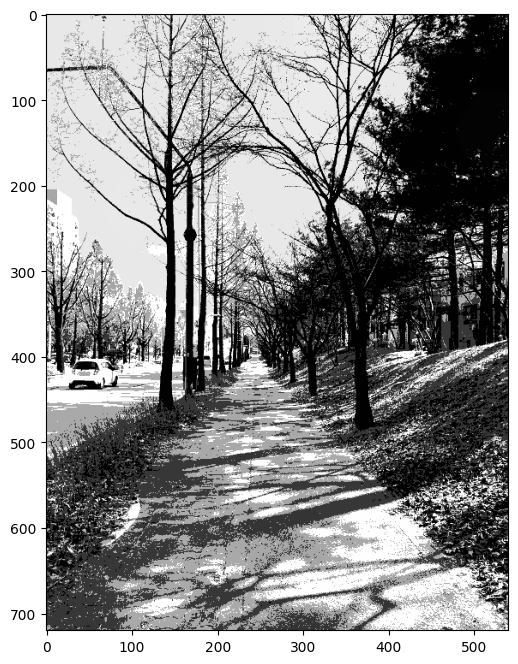

In [15]:
plt.figure(figsize = (12, 8))
plt.imshow(preprocessed_image, cmap = 'gray')
plt.show()

In [17]:
cv2.imwrite("./input/preprocessed_image.jpg", preprocessed_image)

True

STDOUT:
 Feed shape: 768 * 1024, network dataflow time: 0.972453

STDERR:
 2023-11-24 15:08:29.300719: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'cudart64_100.dll'; dlerror: cudart64_100.dll not found
2023-11-24 15:08:29.301172: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.





2023-11-24 15:08:33.472834: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2
2023-11-24 15:08:33.479112: W tensorflow/stream_ex

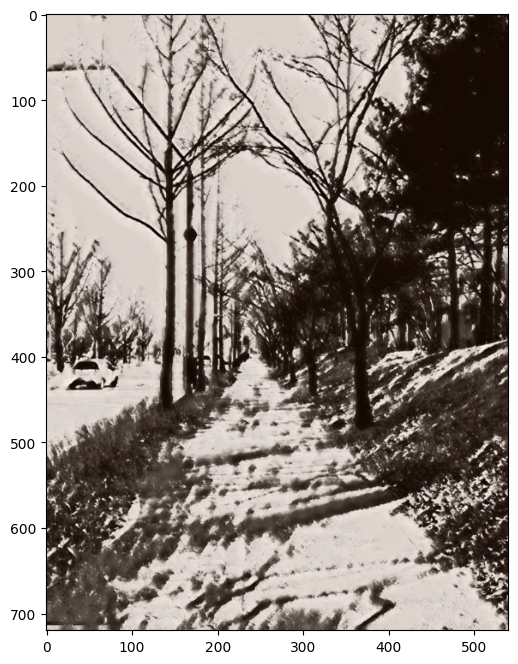

In [25]:
command = 'python render-keep-ratio.py --model model_save --inp "./input/preprocessed_image.jpg" --oup output --size 1024'

# 명령어 실행 및 stdout와 stderr 캡처
result = subprocess.run(command, stdout=subprocess.PIPE, stderr=subprocess.PIPE)

# 실행 결과와 오류 메시지 출력
print("STDOUT:\n", result.stdout.decode())
print("STDERR:\n", result.stderr.decode())

# 이미지를 열어서 저장
result_image = Image.open('output/stylized.jpg')
result_image.save('output/style_transfer_image.jpg')

plt.figure(figsize = (12, 8))
plt.imshow(result_image, cmap = 'gray')
plt.show()